In [68]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from os import path

In [90]:
#
# all.csv contains one row per state with the name of the 
# agri data for that state
#
data = 'data/agri/all.csv'
files = pd.read_csv(data)

states = []
frames = []
for st,fn in files.values.tolist():
    frame = pd.read_csv(path.join('data/agri', fn))
    frame['state'] = st
    states.append(st)
    frames.append(frame)
agri = pd.concat(frames)

In [92]:
#
# Preprocess - convert value to float and invalid values to None
#
def to_float(x):
    try:
        if type(x) == float:
            return x
        x = x.strip()
        if x == '(Z)':
            return 0.0
        x = x.replace(',','')
        return float(x)
    except ValueError:
        return float('NaN')

agri.Value = agri.Value.apply(to_float)
agri = agri[~np.isnan(agri.Value)]
#
# Rename Data Item to DataItem so it can be used as an attribute
# Rename Year to year to match weather data
# Also get rid of some columns we don't need
#
agri['DataItem'] = agri['Data Item']
agri['year'] = agri['Year']
agri = agri.drop(['Data Item', 'Year', 'Program', 'Domain', 'Domain Category'],  1)

#
# We are only interested in items per acre
#
agri = agri[agri.DataItem.str.contains('/ ACRE')]
agri

,Commodity,Value,state,DataItem,year
7929,BARLEY,93.3,CA,"BARLEY, IRRIGATED, ENTIRE CROP - YIELD, MEASUR...",2007
7932,BARLEY,31.9,CA,"BARLEY, IRRIGATED, NONE OF CROP - YIELD, MEASU...",2007
7934,BARLEY,37.8,CA,"BARLEY, IRRIGATED, PART OF CROP - YIELD, MEASU...",2007
7986,BEANS,21.6,CA,"BEANS, DRY EDIBLE, (EXCL LIMA), INCL CHICKPEAS...",2007
8617,CORN,182.2,CA,"CORN, GRAIN, IRRIGATED, ENTIRE CROP - YIELD, M...",2007
...,...,...,...,...,...
17435,TOBACCO,1380.0,WI,"TOBACCO, CIGAR BINDER NORTHERN WISCONSIN (TYPE...",1960
17439,TOBACCO,1510.0,WI,"TOBACCO, CIGAR BINDER SOUTHERN WISCONSIN (TYPE...",1960
17444,WHEAT,33.2,WI,"WHEAT - YIELD, MEASURED IN BU / ACRE",1960
17449,WHEAT,28.0,WI,"WHEAT, SPRING, (EXCL DURUM) - YIELD, MEASURED ...",1960


In [93]:
#
# Split the data up into yields by state
#
bystate = {}
for st in states:
    stdata = agri[agri.state == st]
    comm = list(set(stdata.Commodity))
    crops = {}
    for c in comm:
        rows = stdata[stdata.Commodity == c]
        rows = rows[rows.DataItem.str.contains(c + ' - YIELD')]
        if not rows.empty:
            crops[c] = rows
        
    bystate[st] = crops

In [85]:
data = 'data/wx/wxsummary.csv'
wx = pd.read_csv(data)
wiwx = wx[wx.state == 'WI']
modata = wiwx.loc[:, 'may':'sep'].mean(axis=1)
wiwx = wiwx.copy()
wiwx['mean'] = modata
prcp = wiwx[wiwx['type'] == 'prcp']
prcp = prcp[['year', 'mean']]
tavg = wiwx[wiwx['type'] == 'tavg']
tavg = tavg[['year', 'mean']]

In [118]:
rows = []
for st in bystate.keys():
    for commod in bystate[st].keys():
        merge_prcp = pd.merge(bystate[st][commod], prcp, on='year')
        merge_tavg = pd.merge(bystate[st][commod], tavg, on='year')
        if len(merge_prcp) < 5 or len(merge_tavg) < 5:
            continue
        row = [st, commod, len(merge_prcp), merge_prcp.Value.corr(merged['mean'])]
        row.append(abs(row[3]))
        row += [len(merge_tavg), merge_tavg.Value.corr(merged['mean'])]
        row.append(abs(row[6]))
        
        rows.append(row)
    
corrs = pd.DataFrame(rows, columns=['state', 'crop', 'prcp_years', 'prcp_corr', 'abs_prcp_corr', 'tavg_years', 'tavg_corr', 'abs_tavg_corr'])



In [117]:
with pd.option_context('display.max_rows', None):
    print(corrs[['state', 'crop', 'prcp_years', 'prcp_corr', 'abs_prcp_corr']].sort_values('abs_prcp_corr', ascending=False).head(20))


    state            crop  prcp_years  prcp_corr  abs_prcp_corr
123    NE         HAYLAGE           5  -0.847473       0.847473
103    MS   HAY & HAYLAGE           5  -0.805912       0.805912
154    SD      SUGARBEETS           5  -0.724662       0.724662
8      CA          SQUASH          10   0.705751       0.705751
139    OH   HAY & HAYLAGE           5   0.693135       0.693135
56     IA         HAYLAGE           5   0.688705       0.688705
6      CA      ARTICHOKES          12  -0.688574       0.688574
107    MS         HAYLAGE           5  -0.628618       0.628618
12     CA          GARLIC          12  -0.567357       0.567357
10     CA          CELERY          12  -0.566698       0.566698
52     IA   HAY & HAYLAGE           5   0.524280       0.524280
3      CA   HAY & HAYLAGE           5  -0.514442       0.514442
162    SD         HAYLAGE           5   0.427065       0.427065
109    MS  SWEET POTATOES           5   0.400142       0.400142
80     MI         HAYLAGE          10   

In [119]:
with pd.option_context('display.max_rows', None):
    print(corrs[['state', 'crop', 'tavg_years', 'tavg_corr', 'abs_tavg_corr']].sort_values('abs_tavg_corr', ascending=False).head(20))
    

    state            crop  tavg_years  tavg_corr  abs_tavg_corr
123    NE         HAYLAGE           5  -0.847473       0.847473
103    MS   HAY & HAYLAGE           5  -0.805912       0.805912
154    SD      SUGARBEETS           5  -0.724662       0.724662
8      CA          SQUASH          10   0.705751       0.705751
139    OH   HAY & HAYLAGE           5   0.693135       0.693135
56     IA         HAYLAGE           5   0.688705       0.688705
6      CA      ARTICHOKES          12  -0.688574       0.688574
107    MS         HAYLAGE           5  -0.628618       0.628618
12     CA          GARLIC          12  -0.567357       0.567357
10     CA          CELERY          12  -0.566698       0.566698
52     IA   HAY & HAYLAGE           5   0.524280       0.524280
3      CA   HAY & HAYLAGE           5  -0.514442       0.514442
162    SD         HAYLAGE           5   0.427065       0.427065
109    MS  SWEET POTATOES           5   0.400142       0.400142
80     MI         HAYLAGE          10   

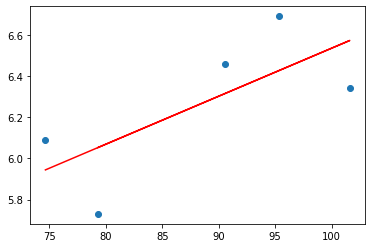

In [123]:
merged = pd.merge(bystate['NE']['HAYLAGE'], prcp, on='year')
model = linear_model.LinearRegression()

meanprcp = [[x] for x in merged['mean']]
model.fit(meanprcp, merged.Value)

m = model.coef_[0]
b = model.intercept_
plt.scatter(merged['mean'], merged.Value)
plt.plot(merged['mean'], m * merged['mean'] + b, color='red')
plt.show()


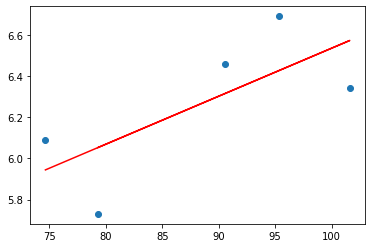

In [124]:
merged = pd.merge(bystate['NE']['HAYLAGE'], prcp, on='year')
model = linear_model.LinearRegression()

meanprcp = [[x] for x in merged['mean']]
model.fit(meanprcp, merged.Value)

m = model.coef_[0]
b = model.intercept_
plt.scatter(merged['mean'], merged.Value)
plt.plot(merged['mean'], m * merged['mean'] + b, color='red')
plt.show()